<a href="https://colab.research.google.com/github/hayleypc/OR-Lookout_Fire/blob/Log-decomposition/log_decomp_decay_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
# raw = pd.read_csv('/content/log_decomp_postfire_raw.csv')

In [15]:
vol = pd.read_csv('/content/log_decomp_postfire_volumes.csv')

In [16]:
# timeseries = pd.read_csv('/content/log_decomp_timeseries.csv')

In [2]:
df = pd.read_csv('/content/TD01421_v1.csv')

In [23]:
# Drop rows where site or log_id is NaN
vol = vol.dropna(subset=['site', 'log_id'])

# Convert to integers
vol['site'] = vol['site'].astype(int)
vol['log_id'] = vol['log_id'].astype(int)

# Drop all unnamed columns
vol = vol.loc[:, ~vol.columns.str.contains('^Unnamed')]

print("Cleaned column names:")
print(vol.columns.tolist())
print("\nCleaned head:")
print(vol.head())
print(f"\nTotal rows: {len(vol)}")

Cleaned column names:
['site', 'log_id', 'species', 'approx_1_m3', 'approx_2_m3', 'prefire_vol_m3', 'vol_init_m3', 'length_init_m', 'x_sect_corr_m', 'fire_vol_reduction_m3', 'fire_reduction_perc', 'notes']

Cleaned head:
   site  log_id species  approx_1_m3  approx_2_m3  prefire_vol_m3  \
0     6     457    THPL       0.6971       0.6971          1.2156   
1     6     458    ABAM       0.1744       0.1744          0.9407   
2     6     459    PSME       0.5325       0.5325          0.9463   
3     6     460    ABAM       0.0000       0.0000          1.2073   
4     6     461    ABAM       0.0000       0.0000          0.5226   

   vol_init_m3  length_init_m  x_sect_corr_m  fire_vol_reduction_m3  \
0       1.6864         5.4600         0.3750                 0.5186   
1       1.3814         5.4900         0.0000                 0.7664   
2       1.0644         5.5300         0.0000                 0.4138   
3       1.7728         5.4900         0.0000                 1.2073   
4       0

In [3]:
print(df.columns.tolist())
print("\n")

['DBCODE', 'ENTITY', 'SITECODE', 'SITE', 'LOG_SPECIES', 'SUBTYPE', 'EQN_FORM', 'N_OBS', 'DECAY_RATE', 'DECAY_RATE_SE', 'INTERCEPT', 'INTERCEPT_SE', 'INTERCEPT_FORCED', 'DECAY_RATE_PV', 'INTERCEPT_PV', 'LAG', 'LAG_SE', 'LAG_PV', 'R_SQUARED', 'OVERALL_PV', 'DECAY_LAG_CORR', 'DECAY_INTERCEPT_CORR', 'P1T0', 'P1T0_SE', 'DECAY_RATE_K1', 'DECAY_RATE_K1_SE', 'DECAY_RATE_K2', 'DECAY_RATE_K2_SE', 'K1_K2_CORR', 'K1_P1T0_CORR']




In [4]:
df.head()

,DBCODE,ENTITY,SITECODE,SITE,LOG_SPECIES,SUBTYPE,EQN_FORM,N_OBS,DECAY_RATE,DECAY_RATE_SE,...,DECAY_LAG_CORR,DECAY_INTERCEPT_CORR,P1T0,P1T0_SE,DECAY_RATE_K1,DECAY_RATE_K1_SE,DECAY_RATE_K2,DECAY_RATE_K2_SE,K1_K2_CORR,K1_P1T0_CORR
0,TD014,21,TD014_ALL,A,ABAM,H,LAG,14,0.055,0.009,...,0.9428,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TD014,21,TD014_ALL,A,ABAM,H,SINGLE,14,0.043,0.003,...,NaN,-0.7403,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TD014,21,TD014_ALL,A,ABAM,O,DUAL,14,NaN,NaN,...,NaN,NaN,0.61,134.39,0.056,2.193,0.038,2.769,0.9988,-0.9997
3,TD014,21,TD014_ALL,A,ABAM,O,LAG,14,0.033,0.009,...,0.9448,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TD014,21,TD014_ALL,A,ABAM,O,SINGLE,14,0.050,0.006,...,NaN,-0.7403,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Found 4 species matching criteria:
   LOG_SPECIES  DECAY_RATE   LAG  N_OBS
7         ABAM       0.055  1.18     14
17        PSME       0.019  1.07     14
27        THPL       0.016  1.26     14
38        TSHE       0.042  1.38     14


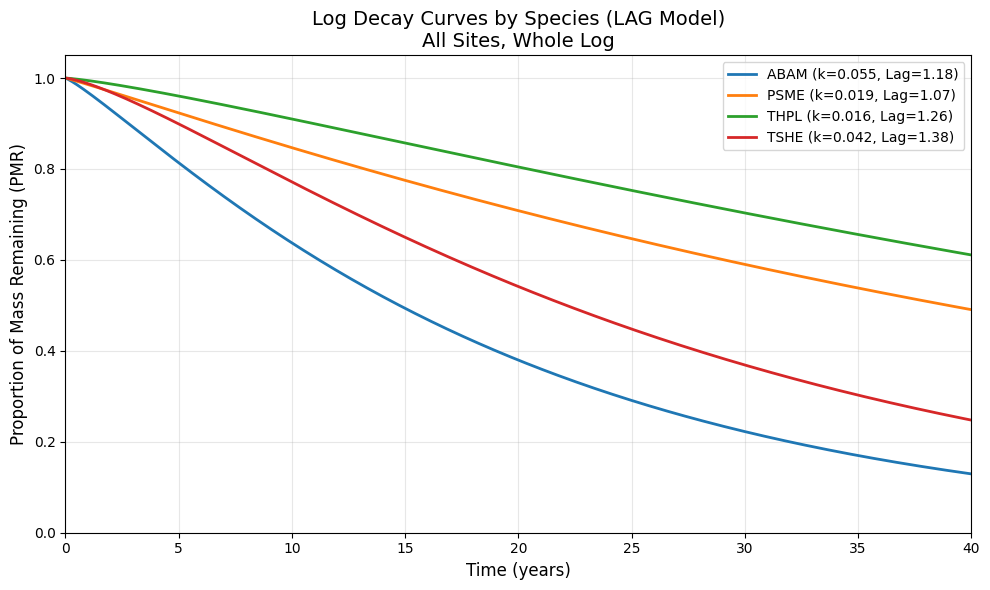

In [6]:
# Filter df
filtered_df = df[(df['SITECODE'] == 'TD014_ALL') &
                  (df['SUBTYPE'] == 'X') &
                  (df['EQN_FORM'] == 'LAG')]

print(f"Found {len(filtered_df)} species matching criteria:")
print(filtered_df[['LOG_SPECIES', 'DECAY_RATE', 'LAG', 'N_OBS']])

# Create time array (0 to 40 years)
t = np.linspace(0, 40, 400)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot decay curve for each species
for idx, row in filtered_df.iterrows():
    species = row['LOG_SPECIES']
    k = row['DECAY_RATE']
    lag = row['LAG']

    # Calculate PMR (proportion of mass remaining) using the LAG equation: PMR = 1-(1-exp(-k*t))^Lag
    PMR = 1 - (1 - np.exp(-k * t))**lag

    plt.plot(t, PMR, label=f"{species} (k={k:.3f}, Lag={lag:.2f})", linewidth=2)

plt.xlabel('Time (years)', fontsize=12)
plt.ylabel('Proportion of Mass Remaining (PMR)', fontsize=12)
plt.title('Log Decay Curves by Species (LAG Model)\nAll Sites, Whole Log', fontsize=14)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.ylim(0, 1.05)
plt.xlim(0, 40)

plt.tight_layout()
plt.show()

Found 4 species matching criteria:
   LOG_SPECIES  DECAY_RATE  INTERCEPT  N_OBS
8         ABAM       0.054       1.06     14
18        PSME       0.017       1.01     14
28        THPL       0.012       1.02     14
39        TSHE       0.034       1.06     14


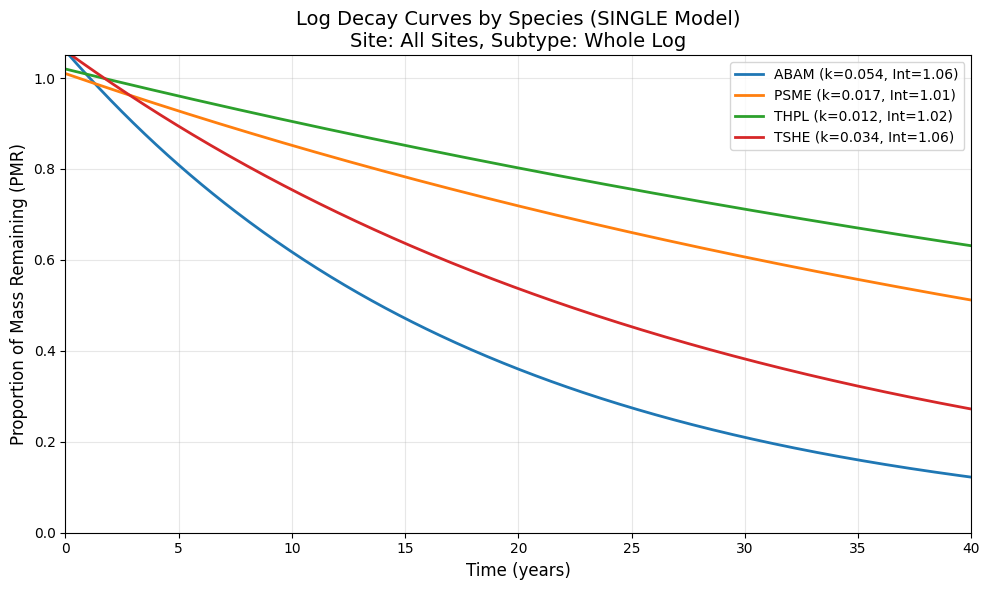

In [7]:
# Filter the dataframe for SINGLE equation form
filtered_df = df[(df['SITECODE'] == 'TD014_ALL') &
                  (df['SUBTYPE'] == 'X') &
                  (df['EQN_FORM'] == 'SINGLE')]

print(f"Found {len(filtered_df)} species matching criteria:")
print(filtered_df[['LOG_SPECIES', 'DECAY_RATE', 'INTERCEPT', 'N_OBS']])

# Create time array (0 to 40 years)
t = np.linspace(0, 40, 400)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot decay curve for each species
for idx, row in filtered_df.iterrows():
    species = row['LOG_SPECIES']
    k = row['DECAY_RATE']
    intercept = row['INTERCEPT']

    # Calculate PMR using the SINGLE equation: PMR = Int*exp(-k*t)
    PMR = intercept * np.exp(-k * t)

    plt.plot(t, PMR, label=f"{species} (k={k:.3f}, Int={intercept:.2f})", linewidth=2)

plt.xlabel('Time (years)', fontsize=12)
plt.ylabel('Proportion of Mass Remaining (PMR)', fontsize=12)
plt.title('Log Decay Curves by Species (SINGLE Model)\nSite: All Sites, Subtype: Whole Log', fontsize=14)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.ylim(0, 1.05)
plt.xlim(0, 40)

plt.tight_layout()
plt.show()

R2 better for the lag model (vs. single) from the original data (14 observations) - prob just go with that


In [8]:
# Filter for LAG model
lag_df = df[(df['SITECODE'] == 'TD014_ALL') &
            (df['SUBTYPE'] == 'X') &
            (df['EQN_FORM'] == 'LAG')].copy()

# Filter for SINGLE model
single_df = df[(df['SITECODE'] == 'TD014_ALL') &
               (df['SUBTYPE'] == 'X') &
               (df['EQN_FORM'] == 'SINGLE')].copy()

# Time at 40 years
t = 40

# Calculate PMR at 40 years for LAG model
lag_df['PMR_40yr'] = 1 - (1 - np.exp(-lag_df['DECAY_RATE'] * t))**lag_df['LAG']

# Calculate PMR at 40 years for SINGLE model
single_df['PMR_40yr'] = single_df['INTERCEPT'] * np.exp(-single_df['DECAY_RATE'] * t)

# Create comparison table
comparison = pd.DataFrame({
    'Species': lag_df['LOG_SPECIES'].values,
    'LAG_PMR_40yr': lag_df['PMR_40yr'].values,
    'SINGLE_PMR_40yr': single_df['PMR_40yr'].values
})

# Add difference column
comparison['Difference'] = comparison['LAG_PMR_40yr'] - comparison['SINGLE_PMR_40yr']

# Format the display
pd.options.display.float_format = '{:.4f}'.format
print("\nProportion of Mass Remaining (PMR) at 40 Years by Species and Equation Form")
print("="*80)
print(comparison.to_string(index=False))
print("\n")


Proportion of Mass Remaining (PMR) at 40 Years by Species and Equation Form
Species  LAG_PMR_40yr  SINGLE_PMR_40yr  Difference
   ABAM        0.1294           0.1222      0.0072
   PSME        0.4906           0.5117     -0.0210
   THPL        0.6110           0.6312     -0.0202
   TSHE        0.2477           0.2721     -0.0244




Found 24 records matching criteria

Data by species and site:
    SITE LOG_SPECIES  DECAY_RATE    LAG  N_OBS
47     1        ABAM      0.0660 1.3200     13
88     2        ABAM      0.0520 0.9600     14
129    3        ABAM      0.0650 1.1800     14
168    4        ABAM      0.0780 1.5600     14
210    5        ABAM      0.0490 1.3200     14
251    6        ABAM      0.0380 1.0600     14
57     1        PSME      0.0100 0.8200     13
98     2        PSME      0.0280 1.4300     14
139    3        PSME      0.0230 1.1600     14
179    4        PSME      0.0150 0.8600     13
221    5        PSME      0.0150 0.9500     14
261    6        PSME      0.0250 1.4700     14
67     1        THPL      0.0220 1.6600     13
108    2        THPL      0.0250 1.6000     14
150    3        THPL      0.0060 0.7300     14
189    4        THPL      0.0110 1.0200     14
231    5        THPL      0.0280 1.9300     14
271    6        THPL      0.0120 1.0700     14
78     1        TSHE      0.0300 1.1200     1

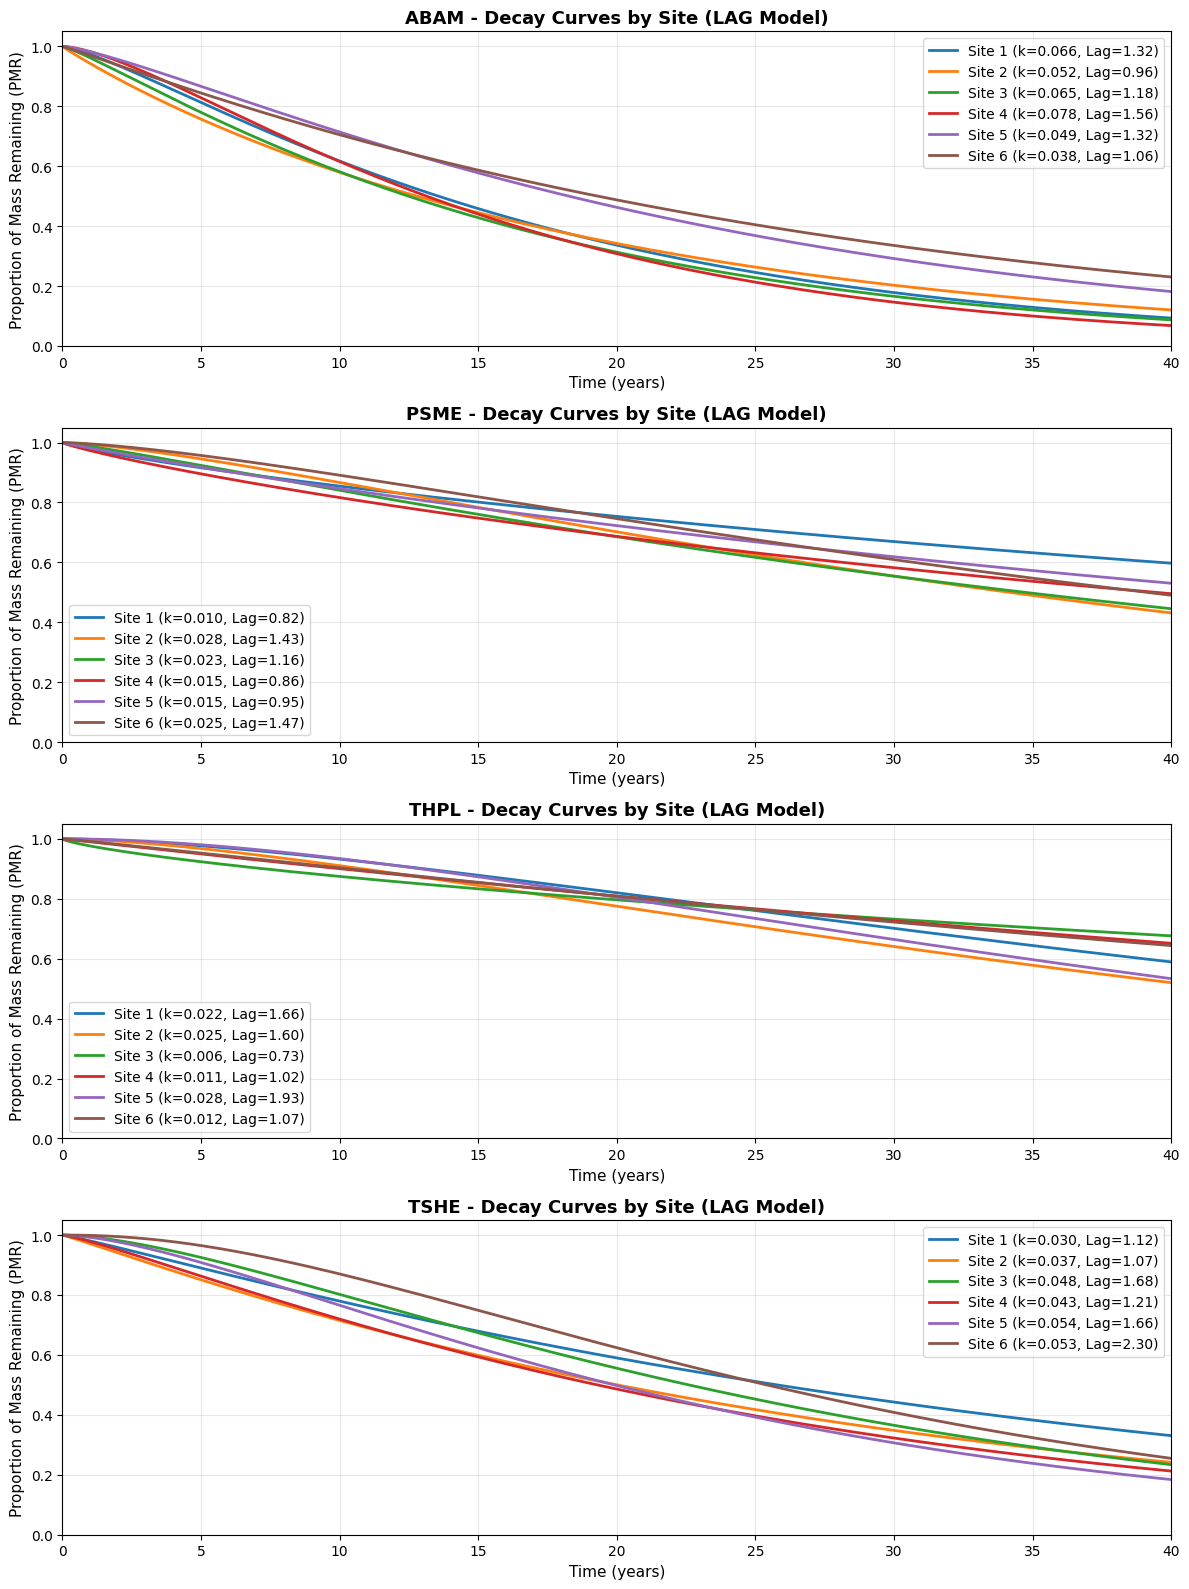

In [9]:
# Filter the dataframe for sites 1-6, subtype X, and LAG equation
filtered_df = df[(df['SITE'].isin(['1', '2', '3', '4', '5', '6'])) &
                  (df['SUBTYPE'] == 'X') &
                  (df['EQN_FORM'] == 'LAG')]

print(f"Found {len(filtered_df)} records matching criteria")
print("\nData by species and site:")
print(filtered_df[['SITE', 'LOG_SPECIES', 'DECAY_RATE', 'LAG', 'N_OBS']].sort_values(['LOG_SPECIES', 'SITE']))

# Create time array (0 to 40 years)
t = np.linspace(0, 40, 400)

# Get unique species
species_list = filtered_df['LOG_SPECIES'].unique()

# Create subplots - one for each species
n_species = len(species_list)
fig, axes = plt.subplots(n_species, 1, figsize=(12, 4*n_species))

# If only one species, make axes iterable
if n_species == 1:
    axes = [axes]

# Plot each species in its own subplot
for ax, species in zip(axes, species_list):
    species_data = filtered_df[filtered_df['LOG_SPECIES'] == species]

    for idx, row in species_data.iterrows():
        site = row['SITE']
        k = row['DECAY_RATE']
        lag = row['LAG']

        # Calculate PMR using the LAG equation
        PMR = 1 - (1 - np.exp(-k * t))**lag

        ax.plot(t, PMR, label=f"Site {site} (k={k:.3f}, Lag={lag:.2f})", linewidth=2)

    ax.set_xlabel('Time (years)', fontsize=11)
    ax.set_ylabel('Proportion of Mass Remaining (PMR)', fontsize=11)
    ax.set_title(f'{species} - Decay Curves by Site (LAG Model)', fontsize=13, fontweight='bold')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1.05)
    ax.set_xlim(0, 40)

plt.tight_layout()
plt.show()

In [10]:
# Filter the dataframe for sites 1-6, subtype X, and LAG equation
filtered_df = df[(df['SITE'].isin(['1', '2', '3', '4', '5', '6'])) &
                  (df['SUBTYPE'] == 'X') &
                  (df['EQN_FORM'] == 'LAG')].copy()

# Time at 40 years
t = 40

# Calculate PMR at 40 years for LAG model
filtered_df['PMR_40yr'] = 1 - (1 - np.exp(-filtered_df['DECAY_RATE'] * t))**filtered_df['LAG']

# Create the table
pmr_table = filtered_df[['SITE', 'LOG_SPECIES', 'DECAY_RATE', 'LAG', 'PMR_40yr']].sort_values(['LOG_SPECIES', 'SITE'])

# Format the display
pd.options.display.float_format = '{:.4f}'.format
print("\nProportion of Mass Remaining (PMR) at 40 Years")
print("Sites 1-6, Subtype: Whole Log (X), Model: LAG")
print("="*80)
print(pmr_table.to_string(index=False))

# Optionally, create a pivot table for easier comparison
print("\n\nPivot Table: PMR at 40 Years (Species × Site)")
print("="*80)
pivot_table = pmr_table.pivot(index='LOG_SPECIES', columns='SITE', values='PMR_40yr')
print(pivot_table)


Proportion of Mass Remaining (PMR) at 40 Years
Sites 1-6, Subtype: Whole Log (X), Model: LAG
SITE LOG_SPECIES  DECAY_RATE    LAG  PMR_40yr
   1        ABAM      0.0660 1.3200    0.0931
   2        ABAM      0.0520 0.9600    0.1202
   3        ABAM      0.0650 1.1800    0.0870
   4        ABAM      0.0780 1.5600    0.0680
   5        ABAM      0.0490 1.3200    0.1816
   6        ABAM      0.0380 1.0600    0.2302
   1        PSME      0.0100 0.8200    0.5974
   2        PSME      0.0280 1.4300    0.4315
   3        PSME      0.0230 1.1600    0.4455
   4        PSME      0.0150 0.8600    0.4956
   5        PSME      0.0150 0.9500    0.5305
   6        PSME      0.0250 1.4700    0.4905
   1        THPL      0.0220 1.6600    0.5891
   2        THPL      0.0250 1.6000    0.5200
   3        THPL      0.0060 0.7300    0.6762
   4        THPL      0.0110 1.0200    0.6513
   5        THPL      0.0280 1.9300    0.5334
   6        THPL      0.0120 1.0700    0.6437
   1        TSHE      0.0300 1.1

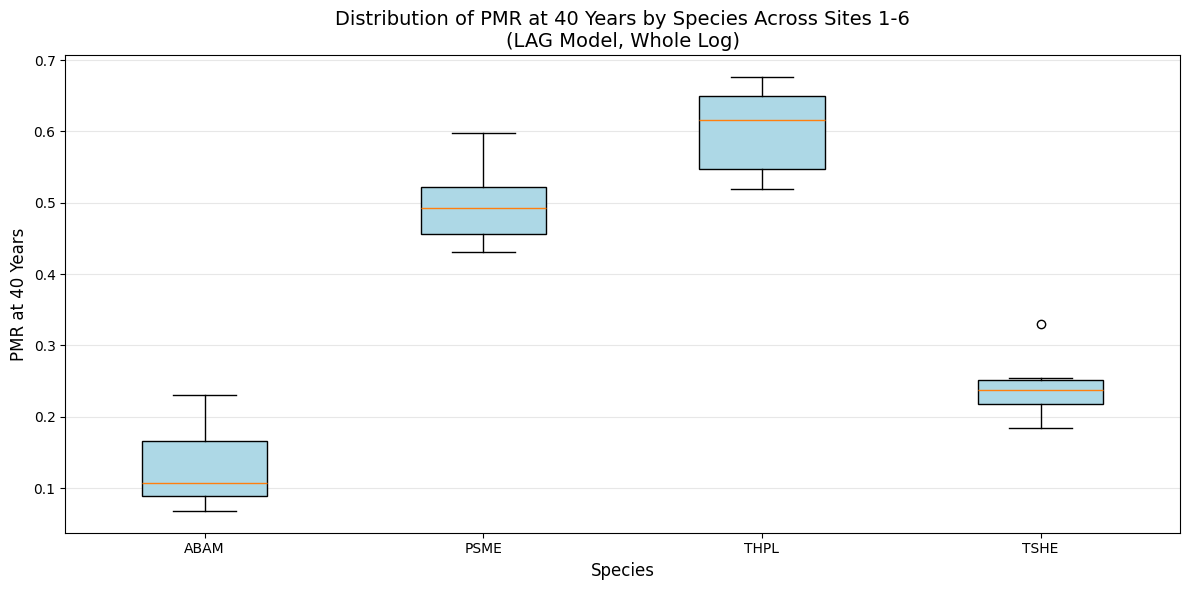

In [17]:
# Filter the dataframe for sites 1-6, subtype X, and LAG equation
filtered_df = df[(df['SITE'].isin(['1', '2', '3', '4', '5', '6'])) &
                  (df['SUBTYPE'] == 'X') &
                  (df['EQN_FORM'] == 'LAG')].copy()

# Time at 40 years
t = 40

# Calculate PMR at 40 years
filtered_df['PMR_40yr'] = 1 - (1 - np.exp(-filtered_df['DECAY_RATE'] * t))**filtered_df['LAG']

# Boxplots by Species (showing variation across sites)
fig, ax = plt.subplots(figsize=(12, 6))

species_list = sorted(filtered_df['LOG_SPECIES'].unique())
pmr_by_species = [filtered_df[filtered_df['LOG_SPECIES'] == sp]['PMR_40yr'].values
                  for sp in species_list]

bp = ax.boxplot(pmr_by_species, tick_labels=species_list, patch_artist=True)

# Color the boxes
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')

ax.set_xlabel('Species', fontsize=12)
ax.set_ylabel('PMR at 40 Years', fontsize=12)
ax.set_title('Distribution of PMR at 40 Years by Species Across Sites 1-6\n(LAG Model, Whole Log)', fontsize=14)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


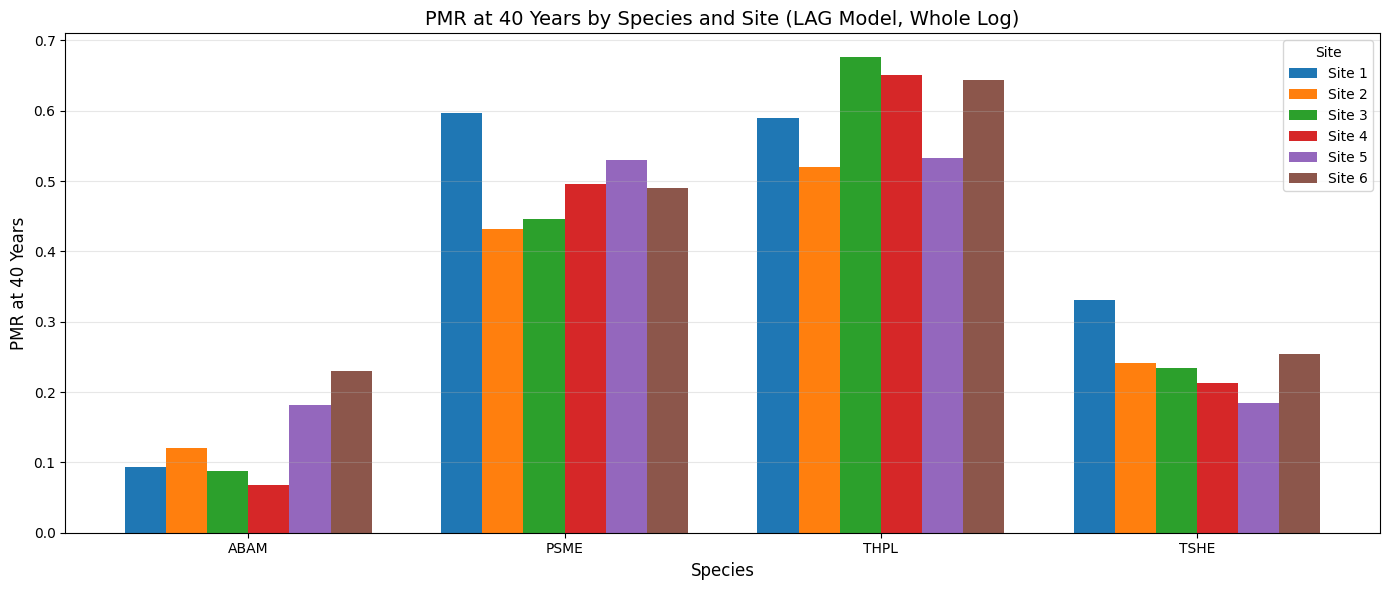

In [18]:
# Grouped Bar Plot (Species grouped by Site)
fig, ax = plt.subplots(figsize=(14, 6))

sites = sorted(filtered_df['SITE'].unique())
species_list = sorted(filtered_df['LOG_SPECIES'].unique())

x = np.arange(len(species_list))
width = 0.13  # width of bars

for i, site in enumerate(sites):
    site_data = filtered_df[filtered_df['SITE'] == site].sort_values('LOG_SPECIES')
    pmr_values = site_data['PMR_40yr'].values
    ax.bar(x + i*width, pmr_values, width, label=f'Site {site}')

ax.set_xlabel('Species', fontsize=12)
ax.set_ylabel('PMR at 40 Years', fontsize=12)
ax.set_title('PMR at 40 Years by Species and Site (LAG Model, Whole Log)', fontsize=14)
ax.set_xticks(x + width * 2.5)
ax.set_xticklabels(species_list)
ax.legend(title='Site')
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

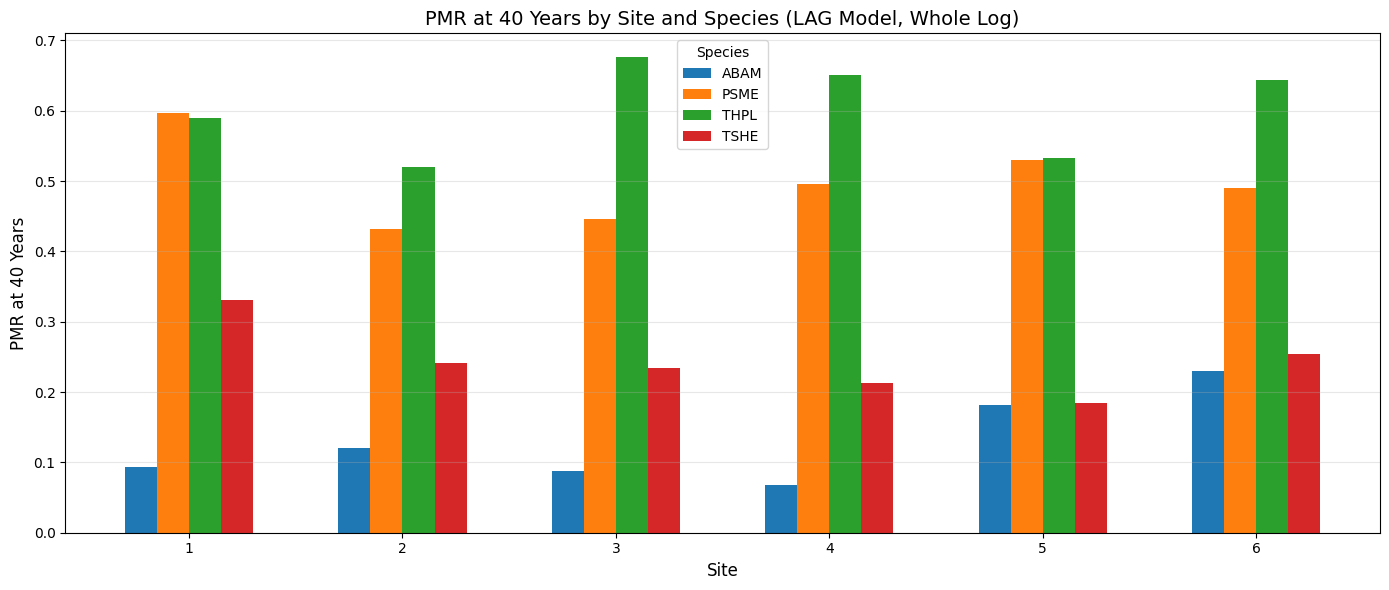

In [19]:
# Grouped Bar Plot (Sites grouped by Species)
fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(sites))
width = 0.15

for i, species in enumerate(species_list):
    species_data = filtered_df[filtered_df['LOG_SPECIES'] == species].sort_values('SITE')
    pmr_values = species_data['PMR_40yr'].values
    ax.bar(x + i*width, pmr_values, width, label=species)

ax.set_xlabel('Site', fontsize=12)
ax.set_ylabel('PMR at 40 Years', fontsize=12)
ax.set_title('PMR at 40 Years by Site and Species (LAG Model, Whole Log)', fontsize=14)
ax.set_xticks(x + width * (len(species_list)-1)/2)
ax.set_xticklabels(sites)
ax.legend(title='Species')
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

In [25]:
# merge vol and df datasets
# decay data is by site and species, volume data is by individual log

# Get the decay parameters for each site/species combination
decay_site = df[(df['SITE'].isin(['1', '2', '3', '4', '5', '6'])) &
                 (df['SUBTYPE'] == 'X') &
                 (df['EQN_FORM'] == 'LAG')].copy()

# Calculate PMR at 40 years
t = 40
decay_site['PMR_40yr'] = 1 - (1 - np.exp(-decay_site['DECAY_RATE'] * t))**decay_site['LAG']

# Create a merge key
decay_site['site'] = decay_site['SITE'].astype(int)
decay_site['species'] = decay_site['LOG_SPECIES']

# Merge with volume data
merged = vol.merge(decay_site[['site', 'species', 'PMR_40yr', 'DECAY_RATE', 'LAG']],
                   on=['site', 'species'],
                   how='left')

print("Merged dataset columns:")
print(merged.columns.tolist())
print("\nFirst few rows:")
print(merged[['site', 'log_id', 'species', 'vol_init_m3', 'prefire_vol_m3',
              'fire_reduction_perc', 'PMR_40yr']].head(10))

Merged dataset columns:
['site', 'log_id', 'species', 'approx_1_m3', 'approx_2_m3', 'prefire_vol_m3', 'vol_init_m3', 'length_init_m', 'x_sect_corr_m', 'fire_vol_reduction_m3', 'fire_reduction_perc', 'notes', 'PMR_40yr', 'DECAY_RATE', 'LAG']

First few rows:
   site  log_id species  vol_init_m3  prefire_vol_m3  fire_reduction_perc  \
0     6     457    THPL       1.6864          1.2156              42.6576   
1     6     458    ABAM       1.3814          0.9407              81.4657   
2     6     459    PSME       1.0644          0.9463              43.7267   
3     6     460    ABAM       1.7728          1.2073             100.0000   
4     6     461    ABAM       0.7674          0.5226             100.0000   
5     6     462    TSHE       1.3543          1.1647              53.3882   
6     6     463    TSHE       1.5716          1.2572              91.2164   
7     6     464    THPL       1.0035          0.7767              55.3419   
8     6     465    TSHE       1.0834          0.9

In [39]:
# Does the decay model predict prefire volume?
merged['predicted_vol_40yr'] = merged['vol_init_m3'] * merged['PMR_40yr']
merged['prediction_error'] = merged['prefire_vol_m3'] - merged['predicted_vol_40yr']
merged['prediction_error_perc'] = (merged['prediction_error'] / merged['vol_init_m3']) * 100

print("\n" + "="*80)
print("Decay Model Prediction vs Observed Prefire Volume - BY SPECIES")
print("="*80)

# Group by species and get summary statistics
for species in sorted(merged['species'].dropna().unique()):
    print(f"\n{'='*80}")
    print(f"SPECIES: {species}")
    print('='*80)
    species_data = merged[merged['species'] == species][['vol_init_m3', 'predicted_vol_40yr',
                                                          'prefire_vol_m3', 'prediction_error',
                                                          'prediction_error_perc', 'PMR_40yr']]
    print(species_data.describe())
    print(f"\nNumber of logs: {len(species_data)}")


# summary table
print("\n" + "="*80)
print("SIMPLIFIED SUMMARY: Mean Values by Species")
print("="*80)
simple_summary = merged.groupby('species')[['vol_init_m3', 'predicted_vol_40yr',
                                             'prefire_vol_m3', 'prediction_error',
                                             'PMR_40yr']].mean()
simple_summary['n_logs'] = merged.groupby('species').size()
pd.options.display.float_format = '{:.4f}'.format
print(simple_summary)


Decay Model Prediction vs Observed Prefire Volume - BY SPECIES

SPECIES: ABAM
       vol_init_m3  predicted_vol_40yr  prefire_vol_m3  prediction_error  \
count      54.0000             54.0000         54.0000           54.0000   
mean        1.1610              0.1897          0.7822            0.5925   
std         0.2489              0.0984          0.1678            0.1318   
min         0.7664              0.0544          0.5219            0.3455   
25%         0.9959              0.0807          0.6666            0.4941   
50%         1.1499              0.2035          0.7763            0.5965   
75%         1.3504              0.2593          0.8728            0.7049   
max         1.7728              0.4081          1.2073            0.8855   

       prediction_error_perc  PMR_40yr  
count                54.0000   54.0000  
mean                 51.4190    0.1599  
std                   7.5459    0.0686  
min                  38.5681    0.0680  
25%                  45.0804   

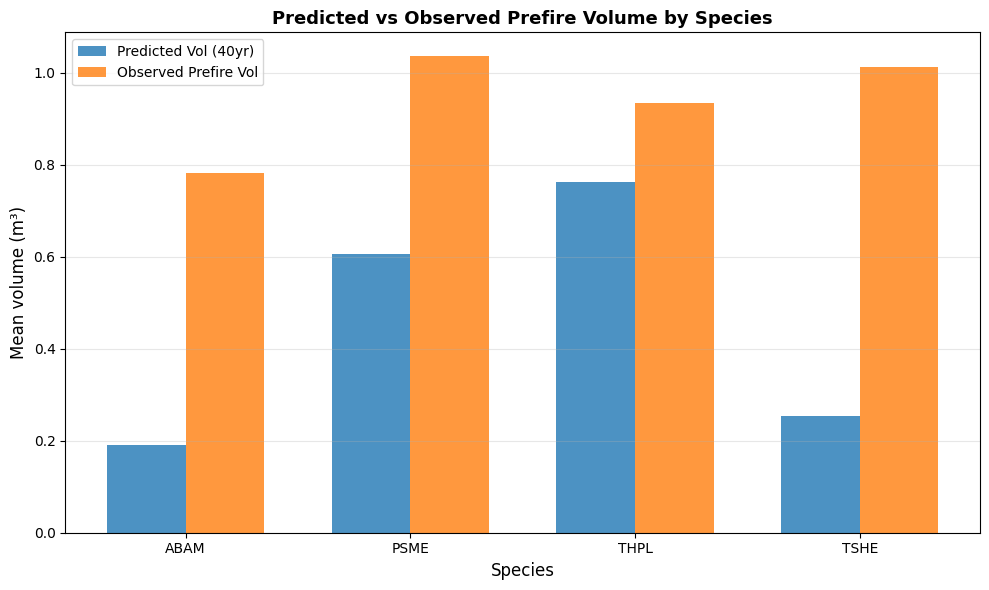

In [67]:
# Calculate summary statistics by species
species_stats = merged.groupby('species')[['vol_init_m3', 'predicted_vol_40yr',
                                            'prefire_vol_m3', 'prediction_error']].mean()

species_list = species_stats.index

# Predicted vs Observed Volume by Species
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(species_list))
width = 0.35

predicted_means = species_stats['predicted_vol_40yr']
observed_means = species_stats['prefire_vol_m3']

ax.bar(x - width/2, predicted_means, width, label='Predicted Vol (40yr)', alpha=0.8)
ax.bar(x + width/2, observed_means, width, label='Observed Prefire Vol', alpha=0.8)

ax.set_xlabel('Species', fontsize=12)
ax.set_ylabel('Mean volume (m³)', fontsize=12)
ax.set_title('Predicted vs Observed Prefire Volume by Species',
             fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(species_list)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()



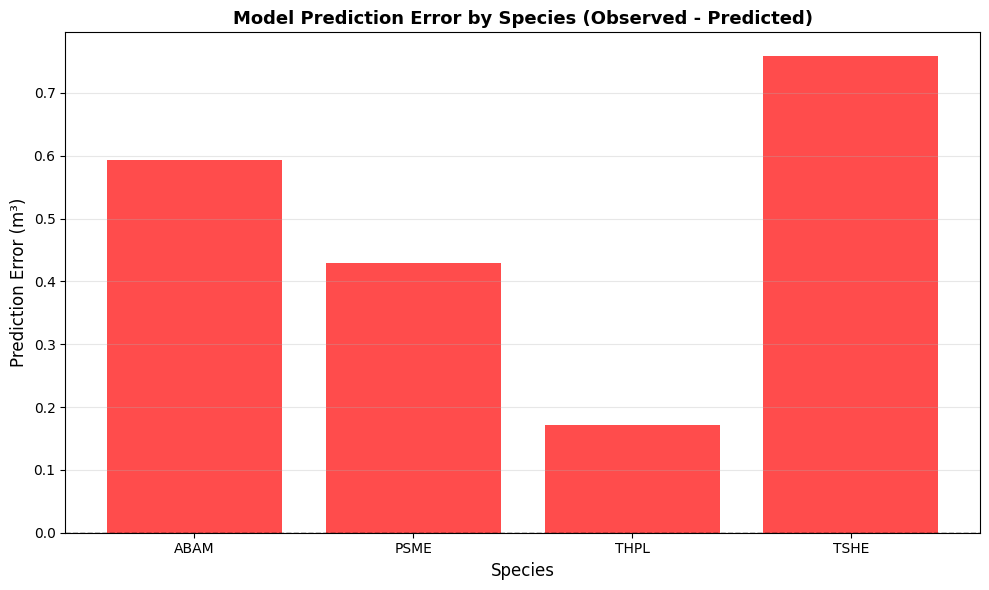

In [49]:
# Prediction Error by Species
fig, ax = plt.subplots(figsize=(10, 6))

error_means = species_stats['prediction_error']

colors = ['red' if err > 0 else 'blue' for err in error_means]
ax.bar(x, error_means, alpha=0.7, color=colors)

ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax.set_xlabel('Species', fontsize=12)
ax.set_ylabel('Prediction Error (m³)', fontsize=12)
ax.set_title('Model Prediction Error by Species (Observed - Predicted)',
             fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(species_list)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

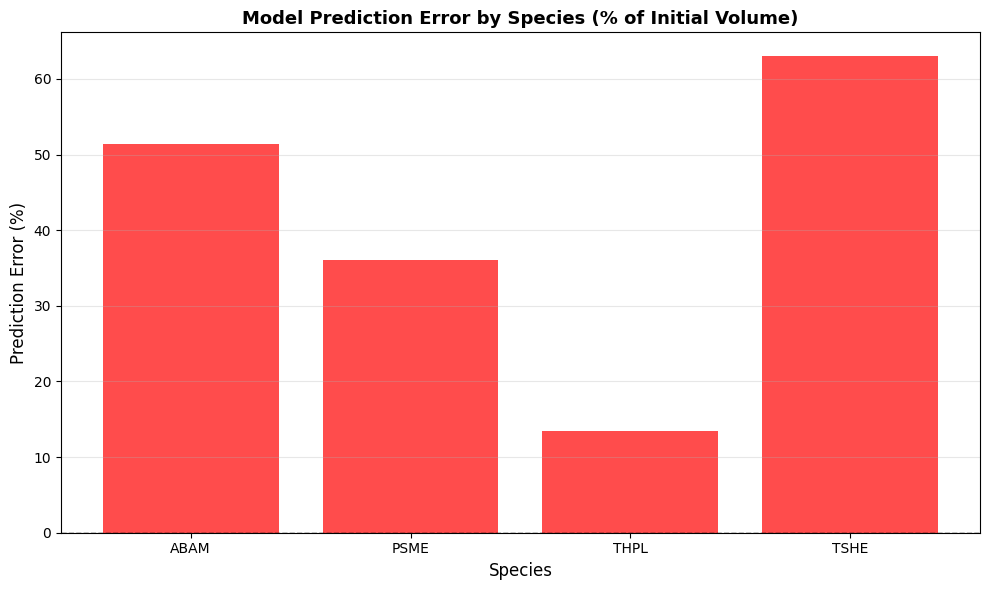

In [51]:
# Percentage Prediction Error by Species
fig, ax = plt.subplots(figsize=(10, 6))

error_perc_means = merged.groupby('species')['prediction_error_perc'].mean()

colors = ['red' if err > 0 else 'blue' for err in error_perc_means]
ax.bar(x, error_perc_means, alpha=0.7, color=colors)

ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax.set_xlabel('Species', fontsize=12)
ax.set_ylabel('Prediction Error (%)', fontsize=12)
ax.set_title('Model Prediction Error by Species (% of Initial Volume)',
             fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(species_list)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

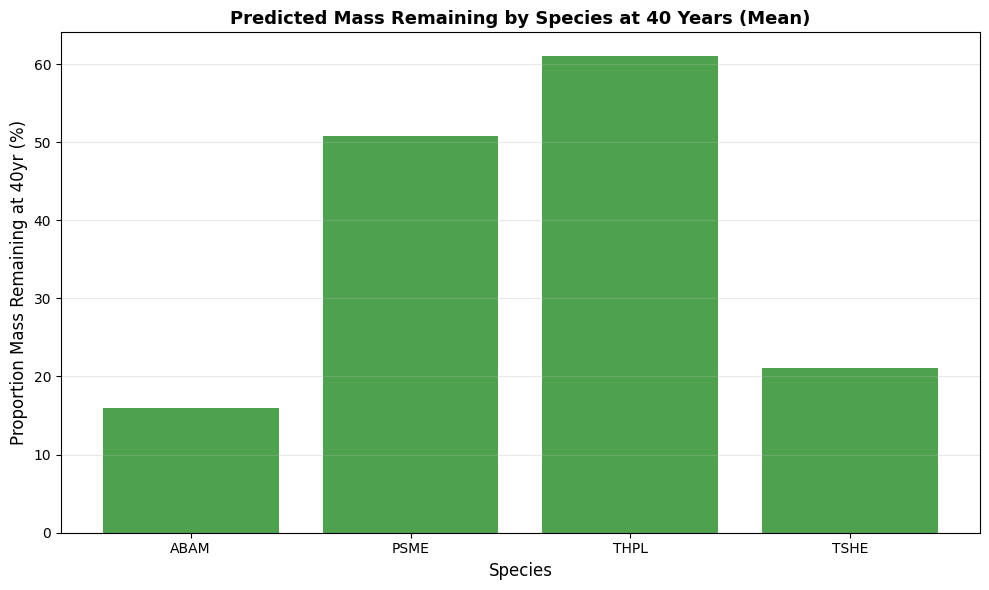

In [52]:
# PMR (Proportion Mass Remaining) by Species
fig, ax = plt.subplots(figsize=(10, 6))

pmr_means = merged.groupby('species')['PMR_40yr'].mean()

ax.bar(x, pmr_means * 100, alpha=0.8, color='forestgreen')

ax.set_xlabel('Species', fontsize=12)
ax.set_ylabel('Proportion Mass Remaining at 40yr (%)', fontsize=12)
ax.set_title('Predicted Mass Remaining by Species at 40 Years (Mean)',
             fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(species_list)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [41]:
# Decay loss vs Fire loss
merged['decay_loss_perc'] = (1 - merged['PMR_40yr']) * 100
merged['total_loss_perc'] = ((merged['vol_init_m3'] - (merged['prefire_vol_m3'] - merged['fire_vol_reduction_m3']))
                              / merged['vol_init_m3']) * 100

print("\n" + "="*80)
print("Decay Loss vs Fire Loss by Species")
print("="*80)
summary = merged.groupby('species')[['decay_loss_perc', 'fire_reduction_perc', 'total_loss_perc']].mean()
print(summary)


Decay Loss vs Fire Loss by Species
         decay_loss_perc  fire_reduction_perc  total_loss_perc
species                                                       
ABAM             84.0058              97.2357          98.1696
PSME             49.1926              54.2685          60.0574
THPL             38.9924              56.2605          67.2049
TSHE             78.8709              82.8523          85.5830


In [45]:
# Does decay state affect fire susceptibility?
print("\n" + "="*80)
print("Correlation between decay state and fire damage")
print("="*80)
correlation = merged[['PMR_40yr', 'fire_reduction_perc']].corr()
print(correlation)
print(f"\nCorrelation coefficient: {merged['PMR_40yr'].corr(merged['fire_reduction_perc']):.4f}")

# Calculate r-squared
r = merged['PMR_40yr'].corr(merged['fire_reduction_perc'])
r_squared = r ** 2

print(f"R-squared (r²): {r_squared:.4f}")

print("More decayed logs (lower PMR) experienced more fire damage. ~40% of variation in fire damage can be explained by decay state")


Correlation between decay state and fire damage
                     PMR_40yr  fire_reduction_perc
PMR_40yr               1.0000              -0.6342
fire_reduction_perc   -0.6342               1.0000

Correlation coefficient: -0.6342
R-squared (r²): 0.4022
More decayed logs (lower PMR) experienced more fire damage. ~40% of variation in fire damage can be explained by decay state


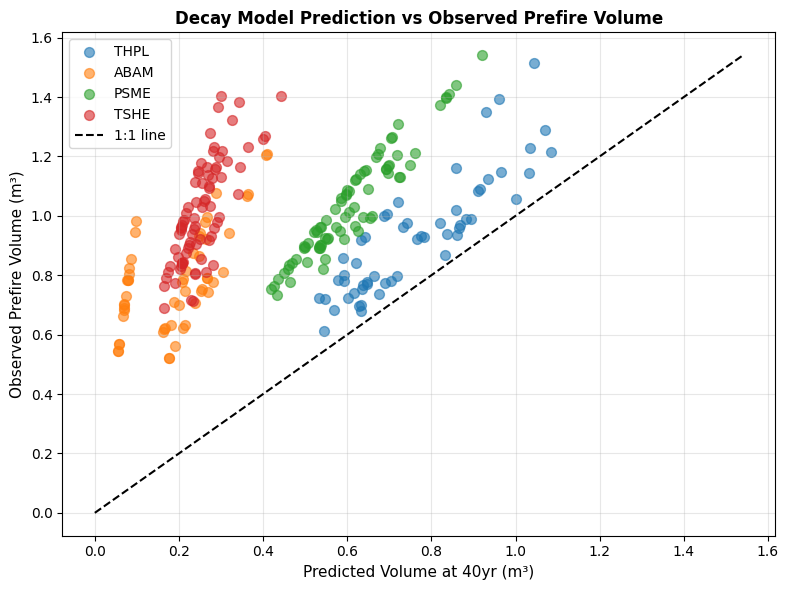

In [68]:
# Predicted vs Observed prefire volume
fig, ax = plt.subplots(figsize=(8, 6))

for species in merged['species'].dropna().unique():
    species_data = merged[merged['species'] == species].dropna(subset=['predicted_vol_40yr', 'prefire_vol_m3'])
    ax.scatter(species_data['predicted_vol_40yr'], species_data['prefire_vol_m3'],
                label=species, alpha=0.6, s=50)

ax.plot([0, merged['prefire_vol_m3'].max()], [0, merged['prefire_vol_m3'].max()],
         'k--', label='1:1 line')
ax.set_xlabel('Predicted Volume at 40yr (m³)', fontsize=11)
ax.set_ylabel('Observed Prefire Volume (m³)', fontsize=11)
ax.set_title('Decay Model Prediction vs Observed Prefire Volume', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

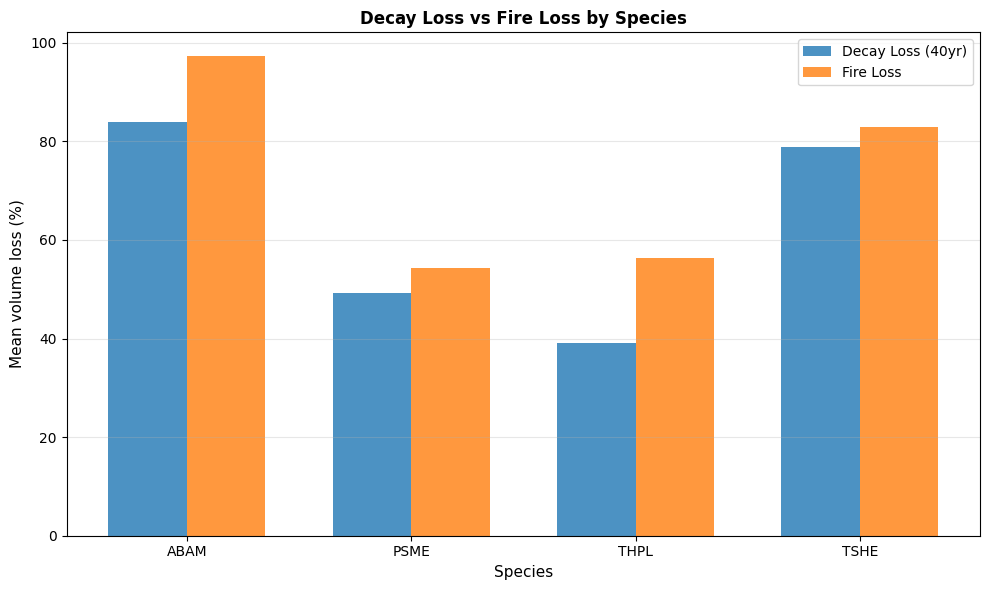

In [69]:
# Decay loss vs Fire loss by species
fig, ax = plt.subplots(figsize=(10, 6))

# Calculate means only
species_summary = merged.groupby('species')[['decay_loss_perc', 'fire_reduction_perc']].mean()

# Extract means
decay_means = species_summary['decay_loss_perc']
fire_means = species_summary['fire_reduction_perc']

x = np.arange(len(decay_means))
width = 0.35

# Create bars without error bars
ax.bar(x - width/2, decay_means, width, label='Decay Loss (40yr)', alpha=0.8)
ax.bar(x + width/2, fire_means, width, label='Fire Loss', alpha=0.8)

ax.set_xlabel('Species', fontsize=11)
ax.set_ylabel('Mean volume loss (%)', fontsize=11)
ax.set_title('Decay Loss vs Fire Loss by Species', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(decay_means.index)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

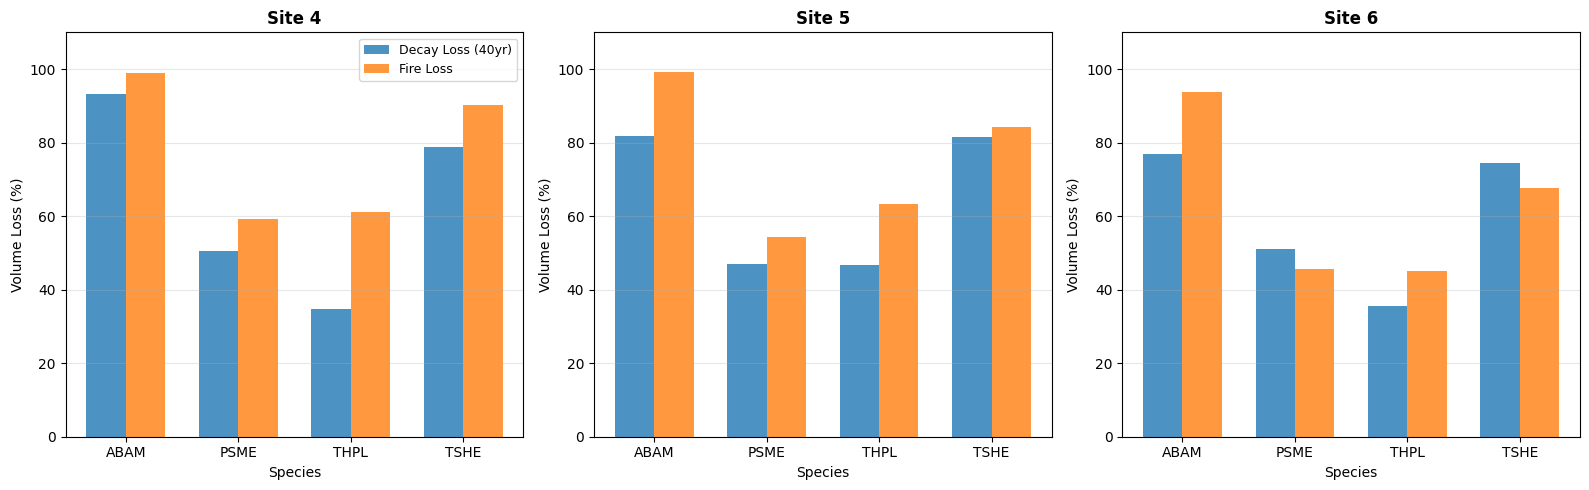

In [71]:
# Separate subplots for sites 4, 5, and 6 only
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
sites = [4, 5, 6]

for idx, site in enumerate(sites):
    ax = axes[idx]

    # Filter data for this site
    site_data = merged[merged['site'] == site].groupby('species')[['decay_loss_perc', 'fire_reduction_perc']].mean()

    if len(site_data) > 0:
        species_in_site = site_data.index
        x = np.arange(len(species_in_site))
        width = 0.35

        decay_means = site_data['decay_loss_perc']
        fire_means = site_data['fire_reduction_perc']

        ax.bar(x - width/2, decay_means, width, label='Decay Loss (40yr)', alpha=0.8)
        ax.bar(x + width/2, fire_means, width, label='Fire Loss', alpha=0.8)

        ax.set_xlabel('Species', fontsize=10)
        ax.set_ylabel('Volume Loss (%)', fontsize=10)
        ax.set_title(f'Site {site}', fontsize=12, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(species_in_site)
        ax.set_ylim(0, 110)  # Set consistent y-axis range

        # Only add legend to the first subplot
        if idx == 0:
            ax.legend(fontsize=9)

        ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


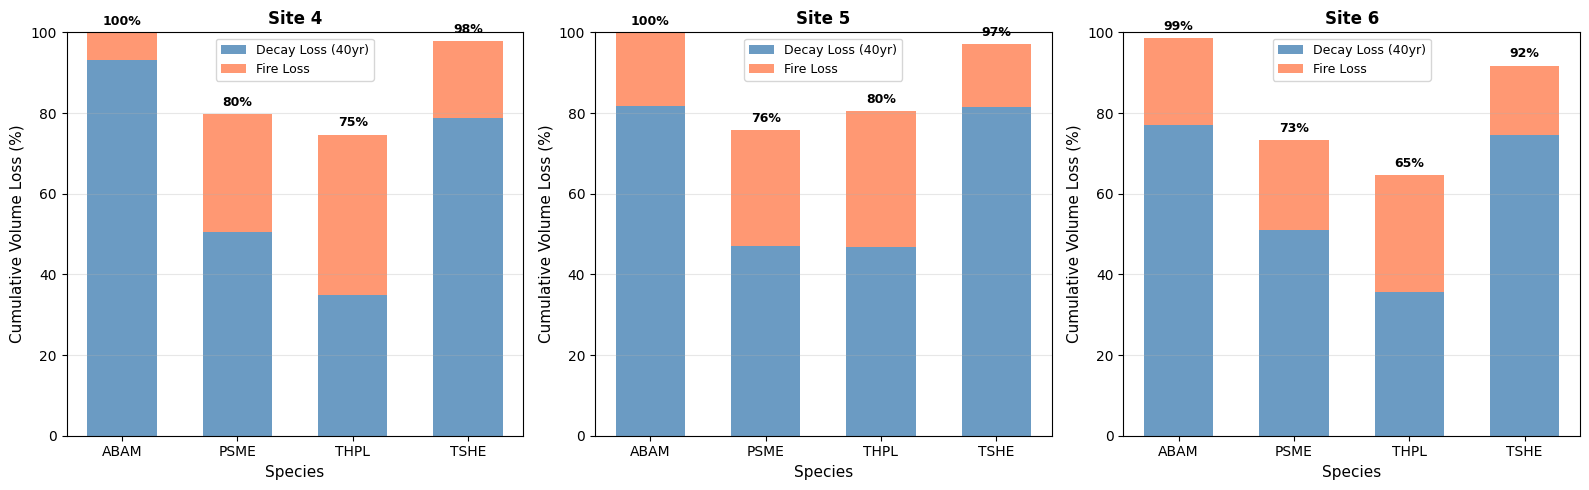

In [63]:
# Calculate total cumulative loss
# Start with initial volume, apply decay, then apply fire to what remains

# After decay: initial_vol * PMR_40yr (what's left after decay)
# After fire: remaining_vol * (1 - fire_loss_proportion)
# Total remaining: initial_vol * PMR_40yr * (1 - fire_loss_proportion)
# Total loss: 100 - (total remaining / initial * 100)

merged['vol_after_decay'] = merged['vol_init_m3'] * merged['PMR_40yr']
merged['fire_loss_proportion'] = merged['fire_vol_reduction_m3'] / merged['prefire_vol_m3']
merged['vol_after_fire'] = merged['vol_after_decay'] * (1 - merged['fire_loss_proportion'])
merged['total_cumulative_loss_perc'] = ((merged['vol_init_m3'] - merged['vol_after_fire']) / merged['vol_init_m3']) * 100

# Stacked bars with correct cumulative loss for sites 4, 5, and 6
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

sites = [4, 5, 6]

for idx, site in enumerate(sites):
    ax = axes[idx]

    # Filter data for this site
    site_data = merged[merged['site'] == site].groupby('species')[['decay_loss_perc', 'total_cumulative_loss_perc']].mean()

    if len(site_data) > 0:
        species_in_site = site_data.index
        x = np.arange(len(species_in_site))
        width = 0.6

        decay_loss = site_data['decay_loss_perc']
        total_loss = site_data['total_cumulative_loss_perc']
        fire_contribution = total_loss - decay_loss  # Fire's contribution to total loss

        # Stacked bars
        ax.bar(x, decay_loss, width, label='Decay Loss (40yr)', alpha=0.8, color='steelblue')
        ax.bar(x, fire_contribution, width, bottom=decay_loss, label='Fire Loss', alpha=0.8, color='coral')

        ax.set_xlabel('Species', fontsize=11)
        ax.set_ylabel('Cumulative Volume Loss (%)', fontsize=11)
        ax.set_title(f'Site {site}', fontsize=12, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(species_in_site)
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3, axis='y')
        ax.set_ylim(0, 100)

        # Add total loss text on top of bars
        for i, species in enumerate(species_in_site):
            total = total_loss[species]
            ax.text(i, total + 2, f'{total:.0f}%', ha='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

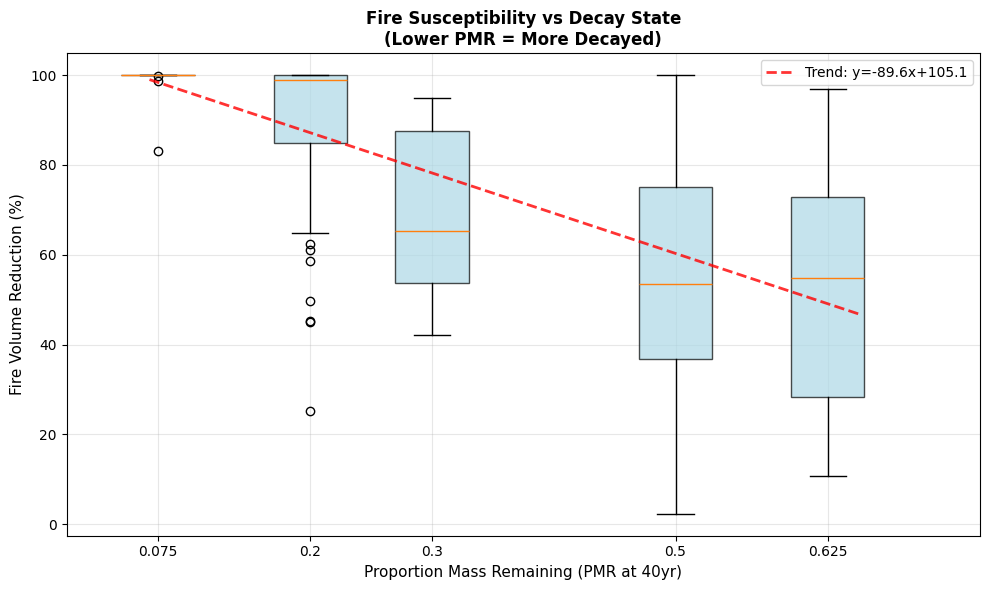


Sample sizes by PMR bin:
PMR_bin
0-0.15       18
0.15-0.25    97
0.25-0.35    18
0.45-0.55    95
0.55-0.70    37
Name: fire_reduction_perc, dtype: int64


In [65]:
# Fire damage vs decay state
fig, ax = plt.subplots(figsize=(10, 6))

# Create bins for PMR values
merged['PMR_bin'] = pd.cut(merged['PMR_40yr'],
                            bins=[0, 0.15, 0.25, 0.35, 0.45, 0.55, 0.70],
                            labels=['0-0.15', '0.15-0.25', '0.25-0.35', '0.35-0.45', '0.45-0.55', '0.55-0.70'])

# Prepare data for boxplots
boxplot_data = []
bin_labels = []
bin_centers = []

for bin_label in merged['PMR_bin'].cat.categories:
    bin_data = merged[merged['PMR_bin'] == bin_label]['fire_reduction_perc'].dropna()
    if len(bin_data) > 0:
        boxplot_data.append(bin_data.values)
        bin_labels.append(bin_label)
        # Calculate bin center for positioning
        bin_range = bin_label.split('-')
        bin_center = (float(bin_range[0]) + float(bin_range[1])) / 2
        bin_centers.append(bin_center)

# Create boxplots
bp = ax.boxplot(boxplot_data, positions=bin_centers, widths=0.06,
                patch_artist=True, showfliers=True)

# Color the boxes
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
    patch.set_alpha(0.7)

# Add trendline using all data points
z = np.polyfit(merged['PMR_40yr'].dropna(),
               merged['fire_reduction_perc'][merged['PMR_40yr'].notna()], 1)
p = np.poly1d(z)
pmr_range = np.linspace(merged['PMR_40yr'].min(), merged['PMR_40yr'].max(), 100)
ax.plot(pmr_range, p(pmr_range), "r--", linewidth=2, alpha=0.8,
        label=f'Trend: y={z[0]:.1f}x+{z[1]:.1f}')

ax.set_xlabel('Proportion Mass Remaining (PMR at 40yr)', fontsize=11)
ax.set_ylabel('Fire Volume Reduction (%)', fontsize=11)
ax.set_title('Fire Susceptibility vs Decay State\n(Lower PMR = More Decayed)',
              fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 0.75)

plt.tight_layout()
plt.show()

# Print sample sizes for each bin
print("\nSample sizes by PMR bin:")
print(merged.groupby('PMR_bin', observed=True)['fire_reduction_perc'].count())

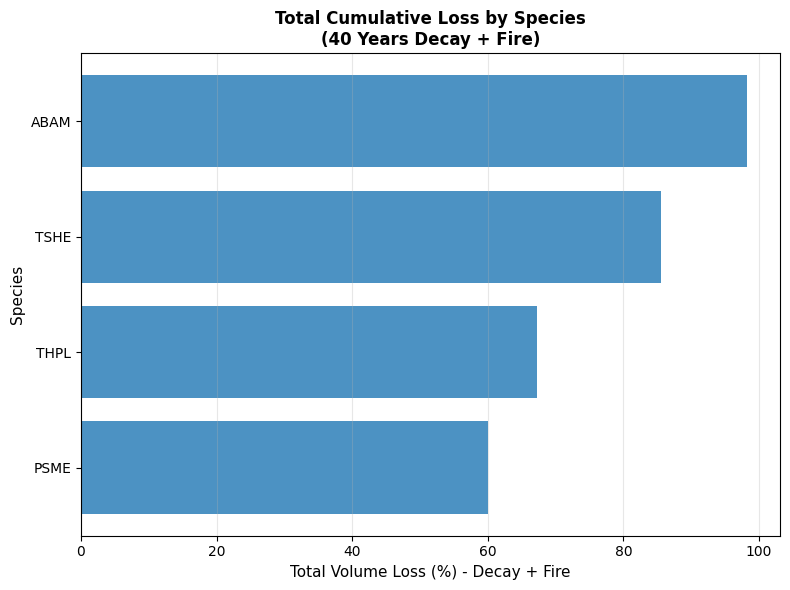

In [66]:
# Total cumulative loss by species
fig, ax = plt.subplots(figsize=(8, 6))

species_total = merged.groupby('species')['total_loss_perc'].mean().sort_values()
ax.barh(range(len(species_total)), species_total.values, alpha=0.8)
ax.set_yticks(range(len(species_total)))
ax.set_yticklabels(species_total.index)
ax.set_xlabel('Total Volume Loss (%) - Decay + Fire', fontsize=11)
ax.set_ylabel('Species', fontsize=11)
ax.set_title('Total Cumulative Loss by Species\n(40 Years Decay + Fire)',
              fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

In [34]:
# Statistical summary
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)
print(f"Average decay loss across all logs: {merged['decay_loss_perc'].mean():.2f}%")
print(f"Average fire loss across all logs: {merged['fire_reduction_perc'].mean():.2f}%")
print(f"Average total loss across all logs: {merged['total_loss_perc'].mean():.2f}%")


SUMMARY STATISTICS
Average decay loss across all logs: 63.02%
Average fire loss across all logs: 71.96%
Average total loss across all logs: 76.92%
